In [ ]:
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
!pip install kaggle -q

from google.colab import files
files.upload()   # upload kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gargavi","key":"a366a9b2f2a90768e6543fa3ab7a8389"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -q
!unzip -q cell-images-for-detecting-malaria.zip

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

# CHANGE THIS PATH IF NEEDED
base_dir = "/content/cell_images"
base_dir = Path(base_dir)

img_size = 128
batch_size = 64
num_epochs = 12
lr = 1e-4
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)


In [ ]:
from torchvision.datasets import ImageFolder

class CleanImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Only valid classes
        valid = ["Parasitized", "Uninfected"]

        classes = []
        for d in os.scandir(directory):
            if d.is_dir() and d.name in valid:
                classes.append(d.name)

        classes.sort()  # ['Parasitized', 'Uninfected']
        class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        return classes, class_to_idx


In [ ]:
# TRANSFORMS
train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# LOAD CLEANED DATASET
full_dataset = CleanImageFolder(base_dir, transform=train_tf)

print("Cleaned classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

# fix val/test transforms
val_ds.dataset.transform = test_tf
test_ds.dataset.transform = test_tf

print("Train:", len(train_ds))
print("Val:", len(val_ds))
print("Test:", len(test_ds))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

Cleaned classes: ['Parasitized', 'Uninfected']
Total images: 27558
Train: 19290
Val: 4133
Test: 4135


In [ ]:
import torchvision.models as models
import torch.nn.functional as F

def get_resnet18(num_classes=2):
    model = models.resnet18(pretrained=True)

    # Freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last 2 blocks (for better learning & Grad-CAM)
    for param in model.layer3.parameters():
        param.requires_grad = True

    for param in model.layer4.parameters():
        param.requires_grad = True

    # Replace final FC layer with Dropout + Linear
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )

    return model.to(device)

model = get_resnet18(num_classes=2)
print("Layer3 & Layer4 UNFROZEN for training + GradCAM++")
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


Layer3 & Layer4 UNFROZEN for training + GradCAM++
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam([
    {"params": model.layer3.parameters()},
    {"params": model.layer4.parameters()},
    {"params": model.fc.parameters()}
], lr=lr)

In [ ]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean().item()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        acc = accuracy(out, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc

    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            acc = accuracy(out, y)
            val_loss += loss.item()
            val_acc += acc

    train_loss /= len(train_loader)
    val_loss   /= len(val_loader)
    train_acc  /= len(train_loader)
    val_acc    /= len(val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/12 | Train Loss: 0.3149, Acc: 0.9419 | Val Loss: 0.2656, Acc: 0.9663
Epoch 2/12 | Train Loss: 0.2550, Acc: 0.9756 | Val Loss: 0.2616, Acc: 0.9690
Epoch 3/12 | Train Loss: 0.2324, Acc: 0.9891 | Val Loss: 0.2690, Acc: 0.9609
Epoch 4/12 | Train Loss: 0.2170, Acc: 0.9969 | Val Loss: 0.2597, Acc: 0.9683
Epoch 5/12 | Train Loss: 0.2128, Acc: 0.9978 | Val Loss: 0.2609, Acc: 0.9675
Epoch 6/12 | Train Loss: 0.2093, Acc: 0.9989 | Val Loss: 0.2576, Acc: 0.9680
Epoch 7/12 | Train Loss: 0.2062, Acc: 0.9997 | Val Loss: 0.2604, Acc: 0.9688
Epoch 8/12 | Train Loss: 0.2046, Acc: 0.9998 | Val Loss: 0.2594, Acc: 0.9678
Epoch 9/12 | Train Loss: 0.2039, Acc: 0.9997 | Val Loss: 0.2606, Acc: 0.9668
Epoch 10/12 | Train Loss: 0.2027, Acc: 0.9999 | Val Loss: 0.2570, Acc: 0.9688
Epoch 11/12 | Train Loss: 0.2019, Acc: 0.9999 | Val Loss: 0.2555, Acc: 0.9709
Epoch 12/12 | Train Loss: 0.2023, Acc: 0.9998 | Val Loss: 0.2585, Acc: 0.9690


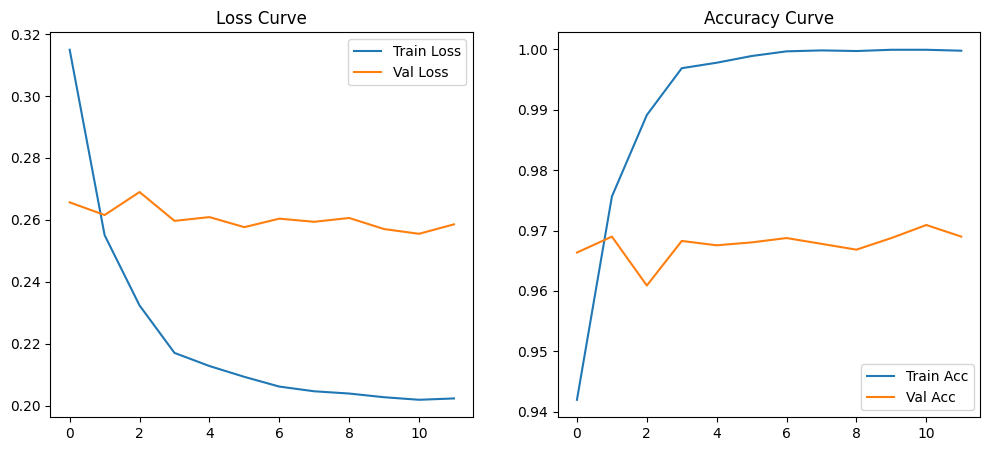

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")

plt.show()


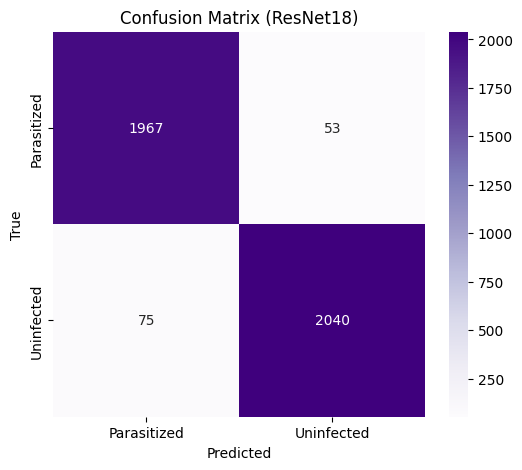

              precision    recall  f1-score   support

 Parasitized       0.96      0.97      0.97      2020
  Uninfected       0.97      0.96      0.97      2115

    accuracy                           0.97      4135
   macro avg       0.97      0.97      0.97      4135
weighted avg       0.97      0.97      0.97      4135



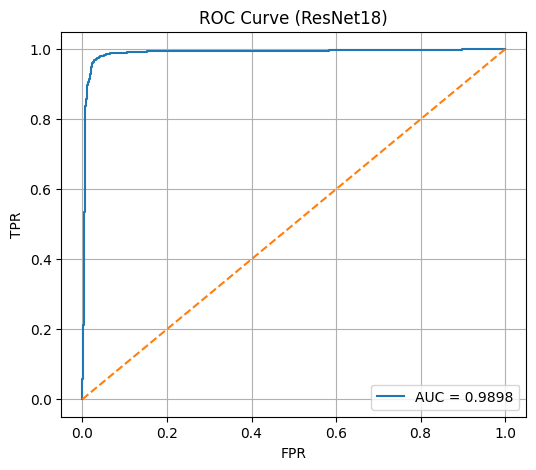

In [ ]:
model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)

        _, preds = torch.max(out, 1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ResNet18)")
plt.show()

print(classification_report(y_true, y_pred,
                            target_names=full_dataset.classes))

fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (ResNet18)")
plt.legend()
plt.grid(True)
plt.show()

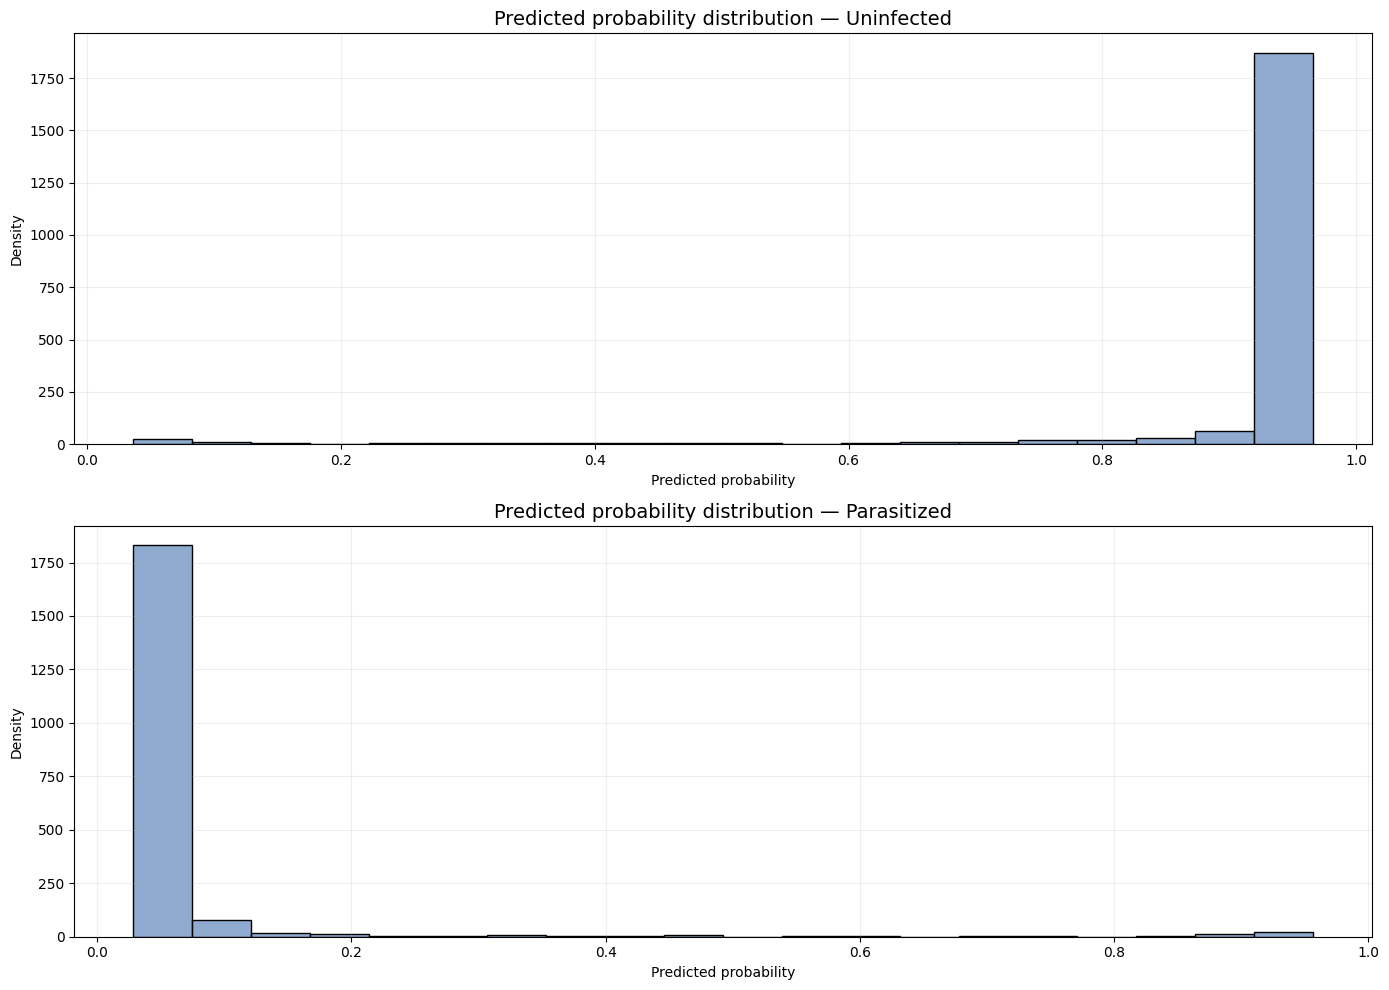

In [ ]:
y_true_arr = np.array(y_true)
y_prob_arr = np.array(y_prob)

probs_uninfected = y_prob_arr[y_true_arr == 1]   # class 1 = Uninfected
probs_parasitized = y_prob_arr[y_true_arr == 0]  # class 0 = Parasitized

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.histplot(probs_uninfected, bins=20, kde=False, color="#6A8FC1")
plt.title("Predicted probability distribution — Uninfected", fontsize=14)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.grid(alpha=0.2)

plt.subplot(2, 1, 2)
sns.histplot(probs_parasitized, bins=20, kde=False, color="#6A8FC1")
plt.title("Predicted probability distribution — Parasitized", fontsize=14)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [ ]:
class GradCAMPP:
    """
    Grad-CAM++ for ResNet18
    Uses forward + backward hooks (no autograd.grad hacks).
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # forward hook: get feature maps
        def forward_hook(module, inp, out):
            self.activations = out

        # backward hook: get gradients wrt feature maps
        def backward_hook(module, grad_input, grad_output):
            # grad_output is a tuple; we want gradients wrt activations
            self.gradients = grad_output[0]

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        # Make sure gradients are enabled
        torch.set_grad_enabled(True)

        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward wrt target class
        loss = output[:, class_idx]
        loss.backward(retain_graph=True)

        # activations & gradients: shape [N, C, H, W]
        activations = self.activations
        gradients = self.gradients

        # Use first sample in batch
        activations = activations[0]   # [C, H, W]
        gradients = gradients[0]       # [C, H, W]

        # Grad-CAM++ weights
        grads_power_2 = gradients ** 2
        grads_power_3 = gradients ** 3

        sum_activations = activations.sum(dim=(1, 2), keepdim=True)  # [C,1,1]

        eps = 1e-7
        alpha_num = grads_power_2
        alpha_denom = 2 * grads_power_2 + sum_activations * grads_power_3
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom) * eps)

        alphas = alpha_num / (alpha_denom + eps)   # [C,H,W]

        positive_gradients = torch.relu(gradients)
        weights = (alphas * positive_gradients).sum(dim=(1, 2))  # [C]

        # Weighted combination of forward activation maps
        cam = (weights[:, None, None] * activations).sum(dim=0)  # [H,W]

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max() + 1e-8

        return cam.detach().cpu().numpy()

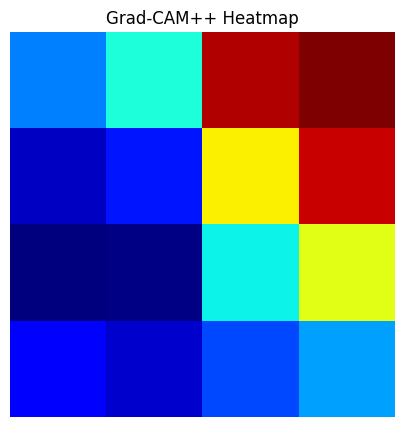

True Label: Parasitized


In [ ]:
def show_gradcampp_heatmap(model, dataset, index=None):
    if index is None:
        index = np.random.randint(0, len(dataset))

    img, label = dataset[index]
    img_tensor = img.unsqueeze(0).to(device)

    # Target layer: last block of layer4
    target_layer = model.layer4[-1]
    gradcampp = GradCAMPP(model, target_layer)
    cam = gradcampp.generate_cam(img_tensor)

    cam_color = plt.cm.jet(cam)[:, :, :3]

    plt.figure(figsize=(5,5))
    plt.imshow(cam_color)
    plt.axis("off")
    plt.title("Grad-CAM++ Heatmap")
    plt.show()

    print("True Label:", full_dataset.classes[label])

# Example call:
show_gradcampp_heatmap(model, test_ds)

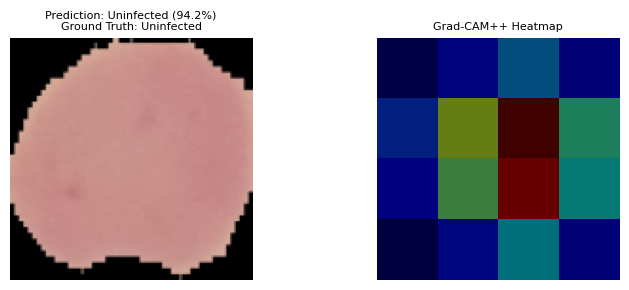

------


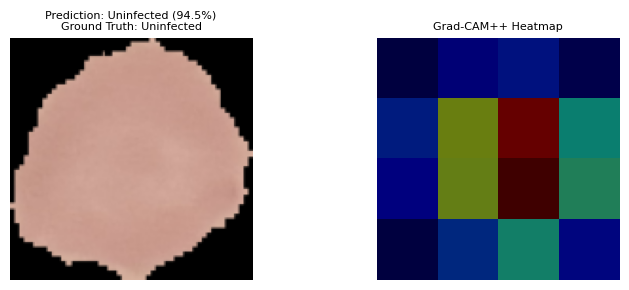

------


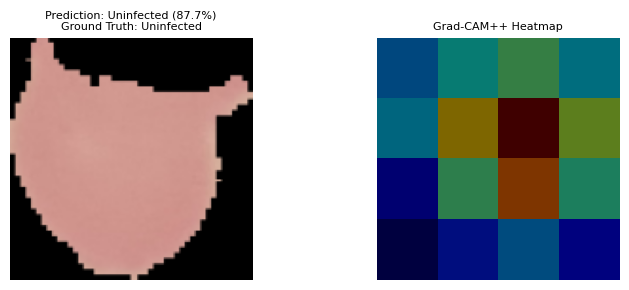

------


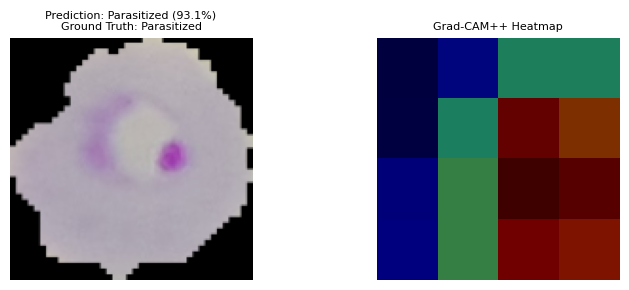

------


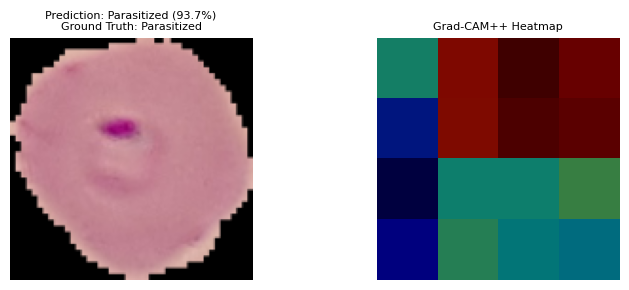

------


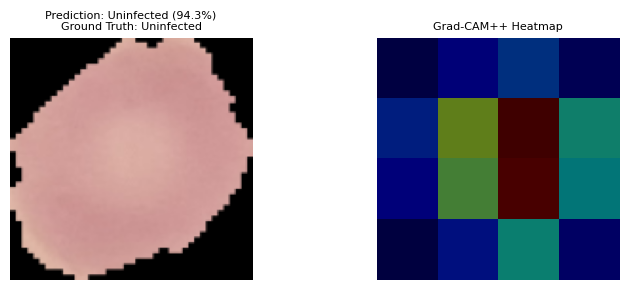

------


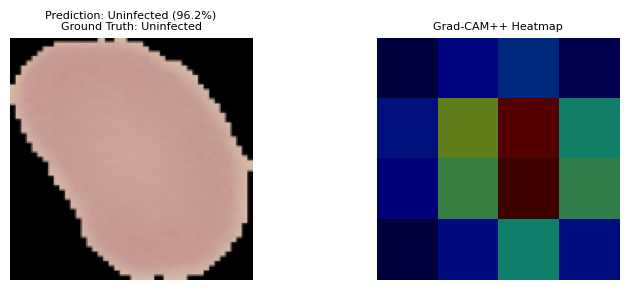

------


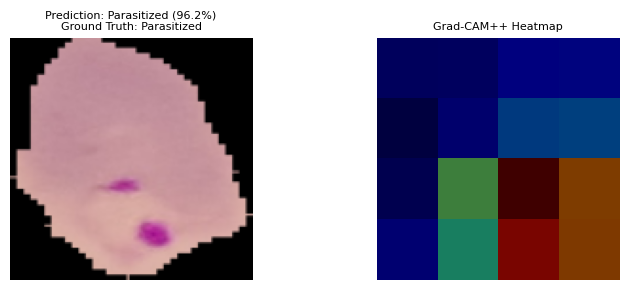

------
Model saved: resnet18_malaria_weights.pth


In [20]:
import random

class_names = full_dataset.classes  # ['Parasitized', 'Uninfected']

def predict_random_image(show_gradcam=False):
    idx = random.randint(0, len(test_ds)-1)

    img, label = test_ds[idx]
    img_tensor = img.unsqueeze(0).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_label = torch.argmax(probs).item()
        confidence = probs[0][pred_label].item()

    if show_gradcam:
        # Grad-CAM++
        target_layer = model.layer4[-1]
        gradcampp = GradCAMPP(model, target_layer)
        cam = gradcampp.generate_cam(img_tensor)

        # ❤️ Perfect Horizontal Layout
        plt.figure(figsize=(8, 3))  # wide and low height → horizontal

        # LEFT = ORIGINAL IMAGE
        ax1 = plt.subplot(1, 2, 1)
        ax1.imshow(img.permute(1,2,0).cpu() * 0.5 + 0.5)
        ax1.set_title(
            f"Prediction: {class_names[pred_label]} ({confidence*100:.1f}%)\n"
            f"Ground Truth: {class_names[label]}",
            fontsize=8
        )
        ax1.axis("off")

        # RIGHT = GRAD-CAM++ OVERLAY
        ax2 = plt.subplot(1, 2, 2)
        ax2.imshow(img.permute(1,2,0).cpu() * 0.5 + 0.5)
        ax2.imshow(cam, cmap='jet', alpha=0.5)
        ax2.set_title("Grad-CAM++ Heatmap", fontsize=8)
        ax2.axis("off")

        plt.tight_layout()
        plt.show()

    else:
        # If not showing Grad-CAM++, show just image
        plt.figure(figsize=(3,3))
        plt.imshow(img.permute(1,2,0).cpu() * 0.5 + 0.5)
        plt.title(
            f"{class_names[pred_label]} ({confidence*100:.1f}%)\n"
            f"GT: {class_names[label]}",
            fontsize=8
        )
        plt.axis("off")
        plt.show()



# Show 8 horizontally placed results
for _ in range(8):
    predict_random_image(show_gradcam=True)
    print("------")

# Save model
torch.save(model.state_dict(), "resnet18_malaria_weights.pth")
print("Model saved: resnet18_malaria_weights.pth")
